# IMPORTACION DE LIBRERIAS Y LECTURA DEL DATASET

In [8]:
# Librerías básicas
import pandas as pd
import numpy as np
from tabulate import tabulate
import math

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid",font_scale=1, palette="pastel")

#Libreria para separacion de datos train y test
import pickle
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, r2_score,  make_scorer, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting

In [9]:
# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = False

In [10]:
def create_pipeline(model, num_cols, cat_cols):

    # Define a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', MinMaxScaler())]), num_cols),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])

    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', model)])

    return pipeline
    

In [11]:
def model_pred(model, X, y, flag):  
    
    pipeline = create_pipeline(model, num_cols, cat_cols)
    
    # Define a column transformer
    #preprocessor = ColumnTransformer(
        #transformers=[
            #('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    #('scaler', MinMaxScaler())]), num_cols),
            #('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                    #('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])

    # Create a pipeline
    #pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                #('model', model)])

    # Define the metrics for evaluation
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted')
    }

    # Perform 5-fold cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=True)

    # Calculate overfitting as the difference between training and validation accuracy
    overfitting = (np.mean(cv_results['train_accuracy']) - np.mean(cv_results['test_accuracy'])) * 100

    y_pred = cross_val_predict(pipeline, X, y)
    


    # Store the evaluation results
    results = {
        'fit_time': np.mean(cv_results['fit_time']),
        'accuracy': np.mean(cv_results['test_accuracy']),
        'f1': np.mean(cv_results['test_f1']),
        'recall': np.mean(cv_results['test_recall']),
        'precision': np.mean(cv_results['test_precision']),
        'overfitting': overfitting,
        'cm': confusion_matrix(y, y_pred),
        #'curva': roc_curve(y, y_pred, pos_label='satisfied'),
        #'curva_total' : roc_auc_score(y, y_pred, pos_label='satisfied')
        
    }

    # Train the model on the entire dataset
    pipeline.fit(X, y)

    # Code to display feature importances
    if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
        print("Model has feature importances. Displaying them.")
        importances = pipeline.named_steps['model'].feature_importances_
        num_features = num_cols
        cat_features = (pipeline.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(input_features=cat_cols))
        all_features = np.concatenate([num_features, cat_features])
        indices = np.argsort(importances)[::-1]
        top_indices = indices[:10]
            
        print("Ranking of most important features:\n")
        for f in range(top_indices.shape[0]):
            print(f"{f + 1}. Feature {all_features[top_indices[f]]} (Importance: {importances[top_indices[f]]})")
        
    if flag:
        # Guardar el pipeline usando Pickle. 
        with open('data_pipeline.pkl', 'wb') as file:
            pickle.dump(pipeline, file)

    return results

In [12]:
# transformador personalizado que realiza la corrección de Camel Case
#class CamelCaseTransformer(BaseEstimator, TransformerMixin):
#    def __init__(self, column_name):
#        self.column_name = column_name
#
#    def fit(self, X, y=None):
#        return self
#
#    def transform(self, X):
#        X_copy = X.copy()
#        X_copy[self.column_name] = X_copy[self.column_name].apply(lambda x: 'Disloyal Customer' if x == 'disloyal Customer' else x)
#        return X_copy

In [13]:
# Function que facilita la exploración básica del dataset
def summary(df):
    total_values = df.shape[0]
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / total_values) * 100
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} rows.")    
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary['Missing %'] = ((missing_data / total_values) * 100).round(2)
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary

In [14]:
#Lectura del dataset
df = pd.read_csv("airline_passenger_satisfaction.csv")

In [15]:
# Configura Pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

df.head(1)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied


# NULOS E IMPUTACION DE NULOS

- Se mira información del dataset: columnas 25, filas 103903, y solo la columna Arrival Delay in Minutes tiene nulos.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

- Se rectifica que solo haya una columna con datos nulos efectivamente solo hay en la columna Arrival Delay in Minutes **310 datos nulos**, posteriormente se decidirá que hacer con estos nulos.

In [17]:
summary(df)

Dataset has 25 features and 103904 rows.


,Unique,Missing,Missing %,Duplicated,Types
Unnamed: 0,103904,0,0.0,0,int64
id,103904,0,0.0,0,int64
Gender,2,0,0.0,0,object
Customer Type,2,0,0.0,0,object
Age,75,0,0.0,0,int64
Type of Travel,2,0,0.0,0,object
Class,3,0,0.0,0,object
Flight Distance,3802,0,0.0,0,int64
Inflight wifi service,6,0,0.0,0,int64
Departure/Arrival time convenient,6,0,0.0,0,int64


**Observaciones**

- Columnas Unnamed, id no creo que sean importantes y se podrían eliminar. Además tienen una cardinalidad muy alta
- La columna Baggage handlingtiene 5 valores en vez de 6 como todas las demás. Empieza en 1 en vez de 0
- Arrival Delay in Minutes es la única que es flotante pasarla a int.
- Arrival Delay in Minutes es la única que tiene missign values = 310, un 0.3% Muy poquito.Imputamos

- Revisamos los valores unicos de la columna "Arrival Delay in Minutes" para ver si se podia pasar de float a int.

In [18]:
# Utiliza el método unique() para obtener todos los valores únicos
unique_values = df['Arrival Delay in Minutes'].unique()

# Muestra todos los valores únicos en la columna 'Arrival Delay in Minutes'
#for value in unique_values:
    #print(value)

In [19]:
# Para llenar los valores nulos con la media: (MIRAR SI SE IMPUTAN CON MEDIA O MEDIANA)
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())

In [20]:
df['Arrival Delay in Minutes'].head()

0    18.0
1     6.0
2     0.0
3     9.0
4     0.0
Name: Arrival Delay in Minutes, dtype: float64

- La columna 'Arrival Delay in Minutes' se puede pasar a int ya que no tiene valores que se consideren decimales.

In [21]:
# Para convertir una columna de tipo float a int 
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)

In [22]:
df['Arrival Delay in Minutes'].head()

0    18
1     6
2     0
3     9
4     0
Name: Arrival Delay in Minutes, dtype: int64

### SE BORRAN COLUMNAS QUE NO SIRVEN 

In [23]:
columna_a_borrar = ['Unnamed: 0', "id"]
df = df.drop(columna_a_borrar, axis=1)

# Exploratory Data Analysis (EDA)
## Target Variable

<Axes: xlabel='satisfaction', ylabel='count'>

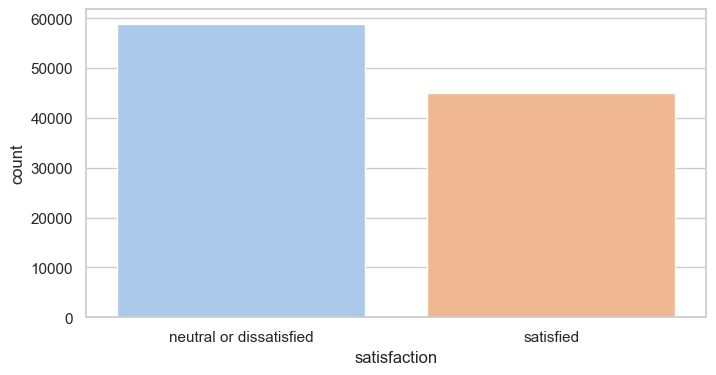

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='satisfaction')

In [25]:
opiniones_neutral_or_dissatisfied =(df['satisfaction'] == 'neutral or dissatisfied').sum()
# Imprimir la suma de opiniones "neutral or dissatisfied"
print("Suma de opiniones 'neutral or dissatisfied':", opiniones_neutral_or_dissatisfied)

Suma de opiniones 'neutral or dissatisfied': 58879


In [26]:
opiniones_satisfied=(df['satisfaction'] == 'satisfied').sum()
# Imprimir la suma de opiniones "satisfied"
print("Suma de opiniones 'satisfied':",opiniones_satisfied)

Suma de opiniones 'satisfied': 45025


- La variable esta balanceada, de momento se puede dejar asi, en caso de que estuviese desbalanceada se aplicarian tecnicas para balancear los datos y que el modelo funcionara mucho mejor.

### GRAFICA DE SERVICIOS DE LA AEROLINEA

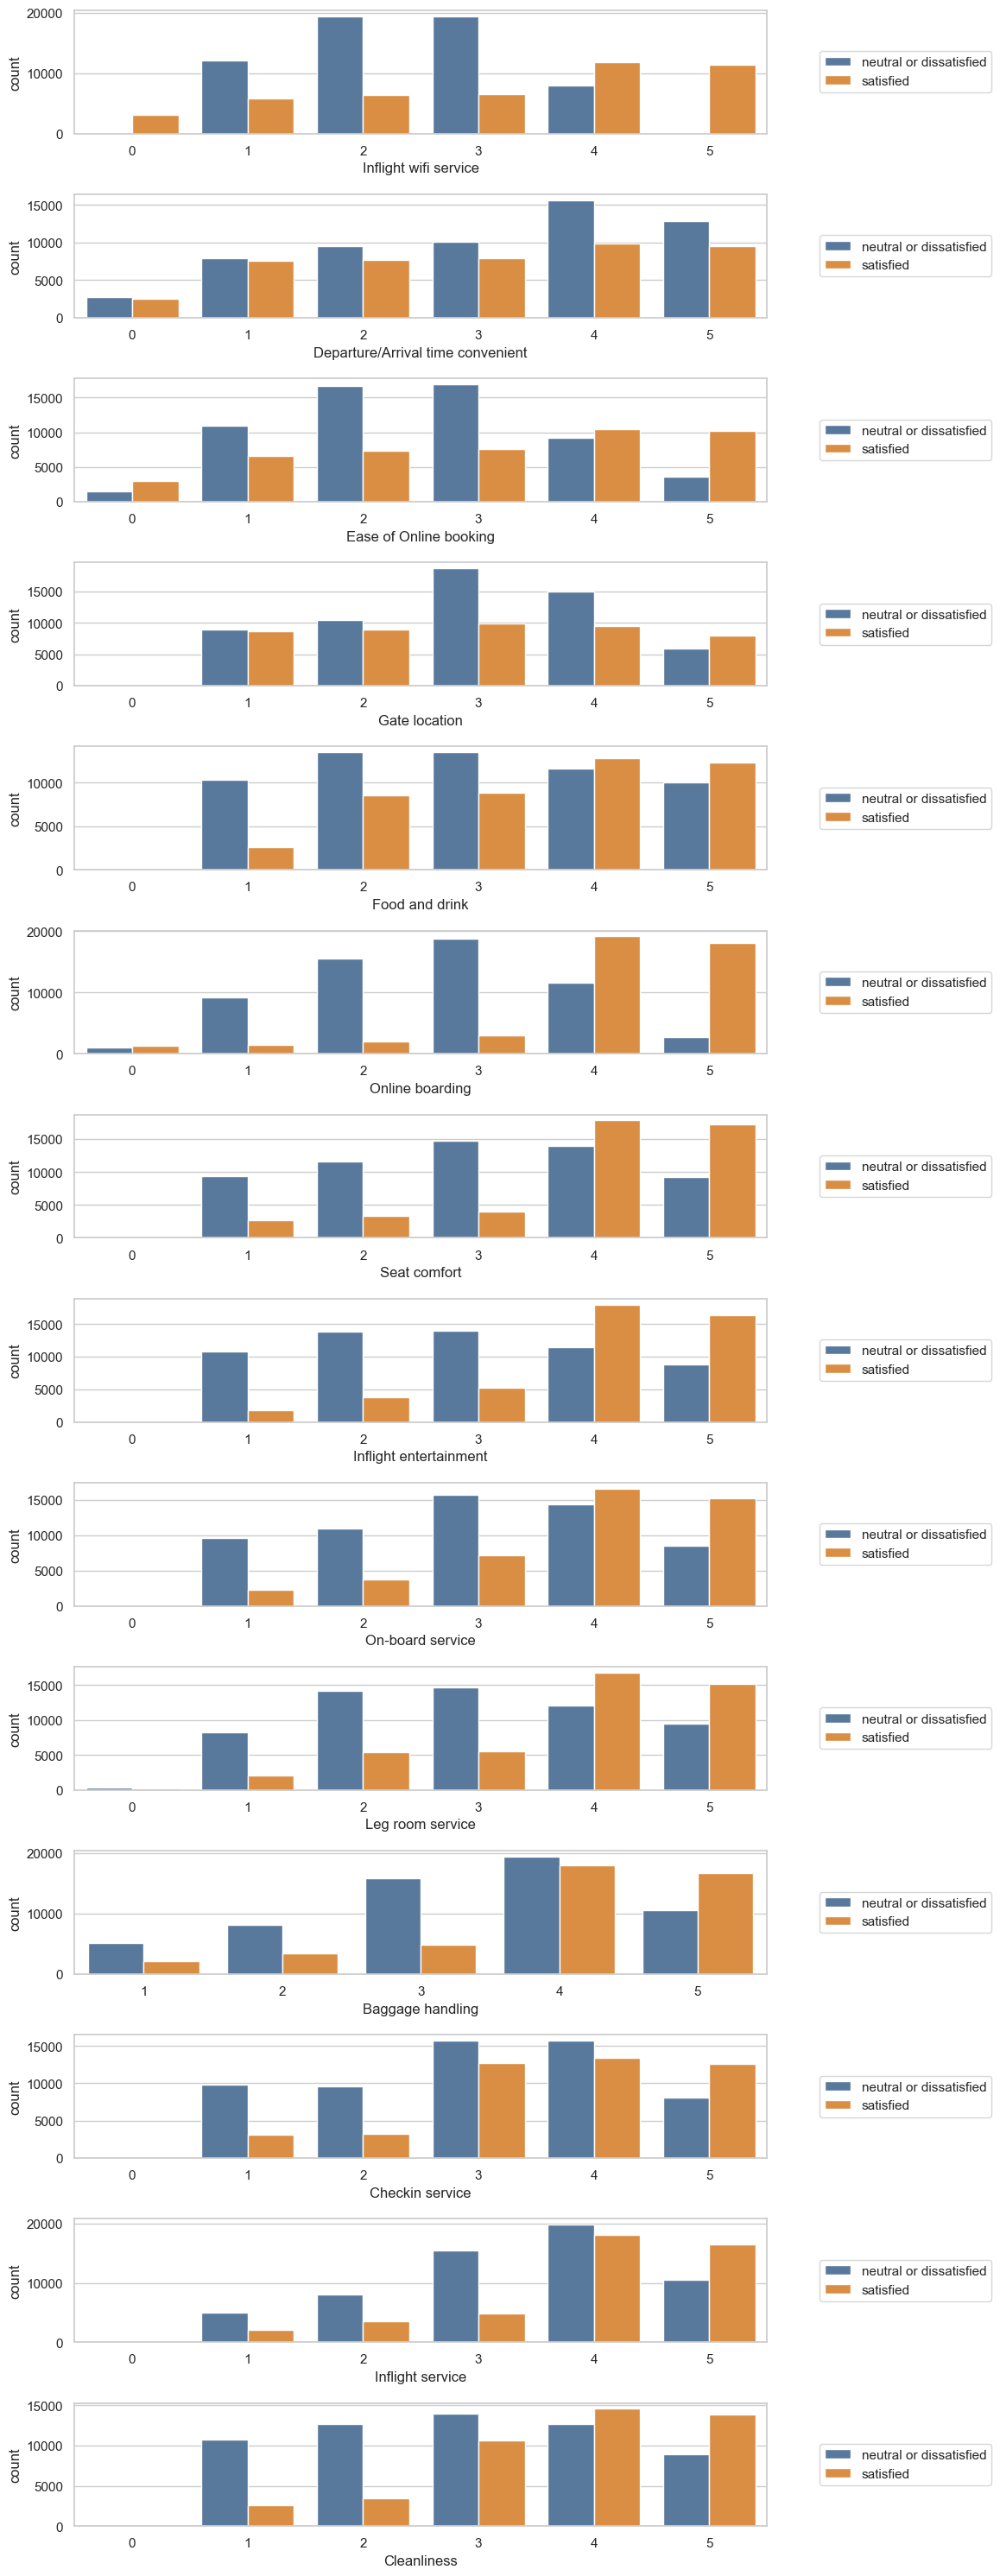

In [27]:
services = ["Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", 'Gate location', 'Food and drink', 
            'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling',
            'Checkin service', 'Inflight service', 'Cleanliness']

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 30))  # Aumenta el valor 30 para adaptarlo a la cantidad de subplots que tengas

for idx, column in enumerate(services):
    plt.subplot(len(services), 1, idx+1)
    sns.countplot(x=column, hue="satisfaction", data=df, palette=["#4e79a7", "#f28e2b"])
    plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5))

# Ajustar la disposición de las subtramas
plt.tight_layout()

# Mostrar la figura
plt.show()

# ANALISIS DE VARIABLES NUMERICAS

In [28]:
df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178145
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.640910
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [29]:
num_cols = ["Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking",
                 "Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service",
                 "Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness","Departure Delay in Minutes",
                 "Arrival Delay in Minutes"]

### SE GRAFICAN OUTLIERS DE TODAS LAS COLUMNAS

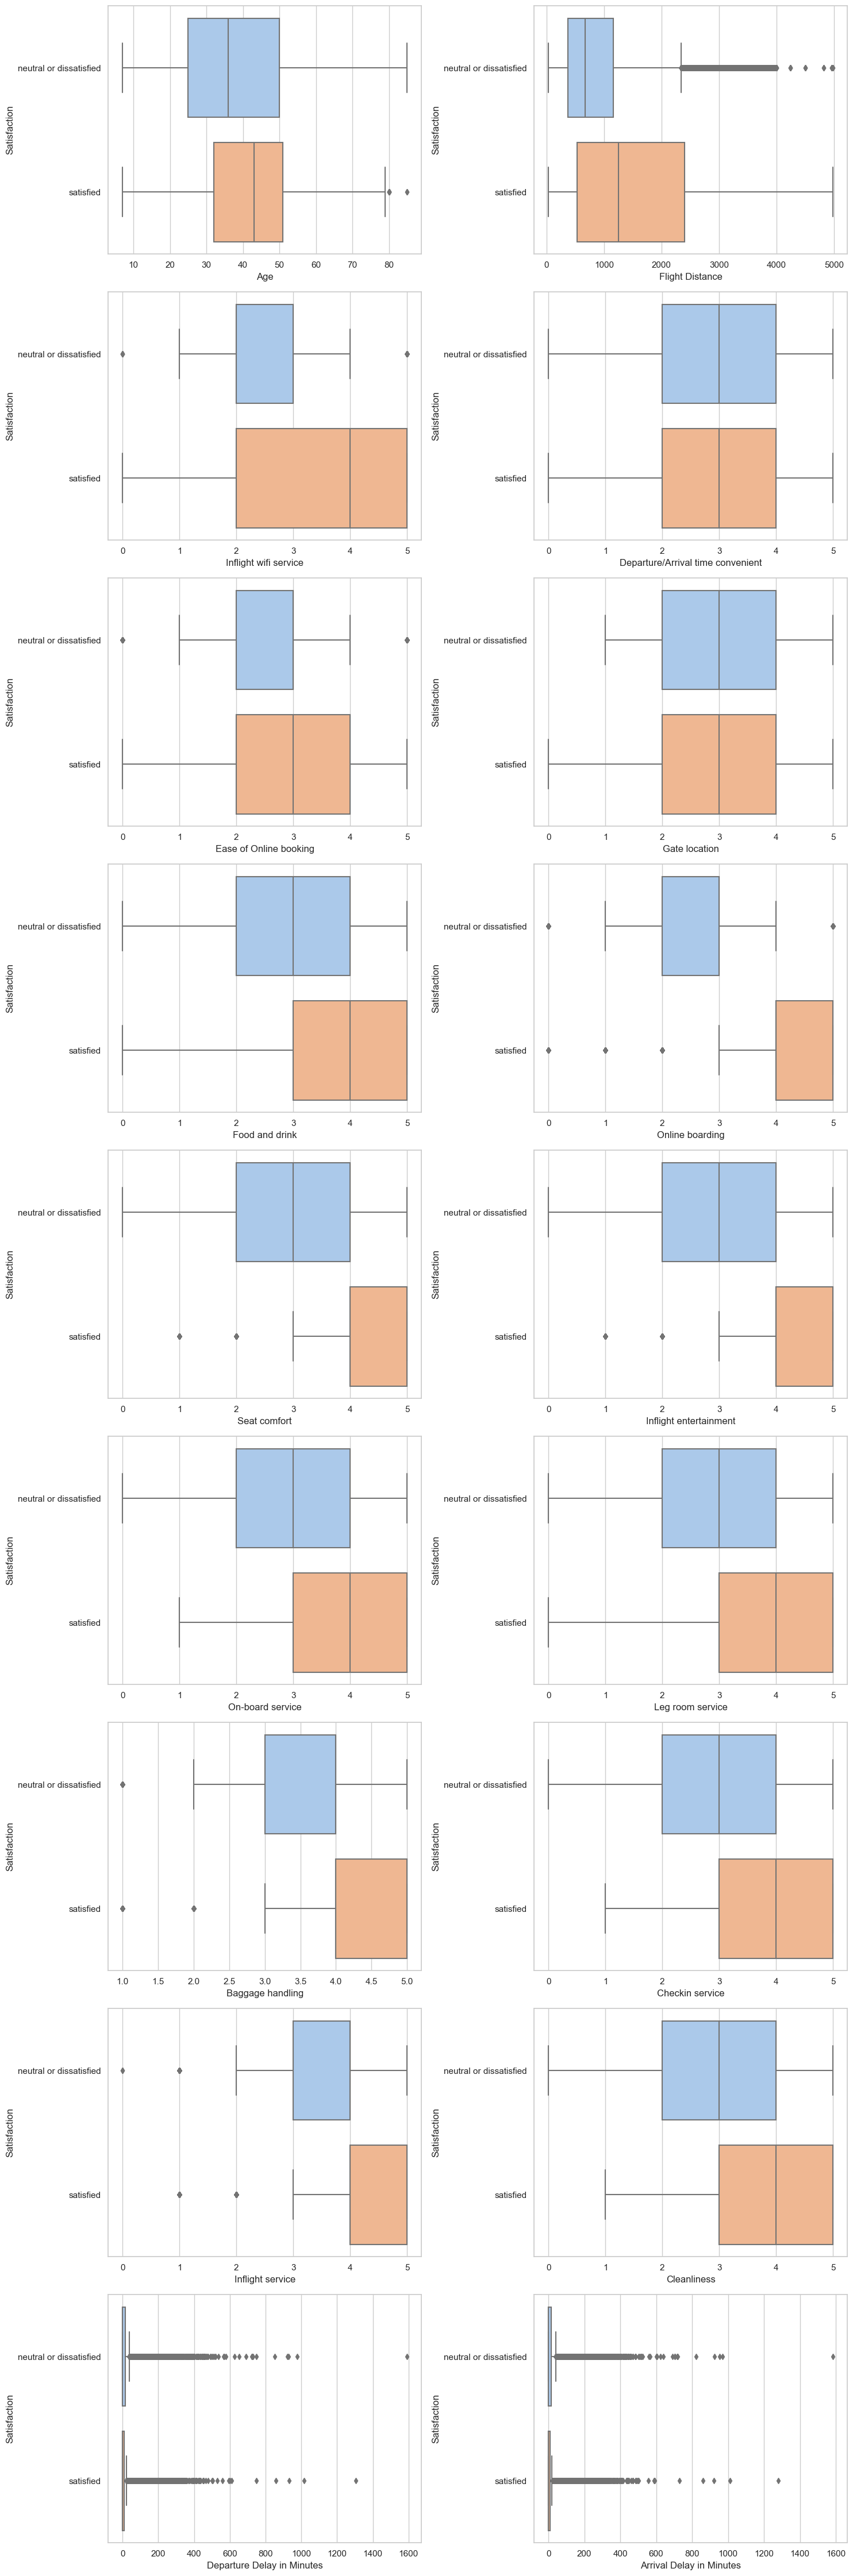

In [30]:
n_rows, n_cols = math.ceil(len(num_cols) / 2), 2
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for num_col in num_cols:
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data=df, x=num_col, y="satisfaction", ax=ax[row, col])
    ax[row, col].set_xlabel(num_col, fontsize=12)
    ax[row, col].set_ylabel('Satisfaction', fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

### ANALISIS DE COLUMNA "AGE"

In [31]:
df['Age'].describe()

count    103904.000000
mean         39.379706
std          15.114964
min           7.000000
25%          27.000000
50%          40.000000
75%          51.000000
max          85.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Age Feature Distribution')

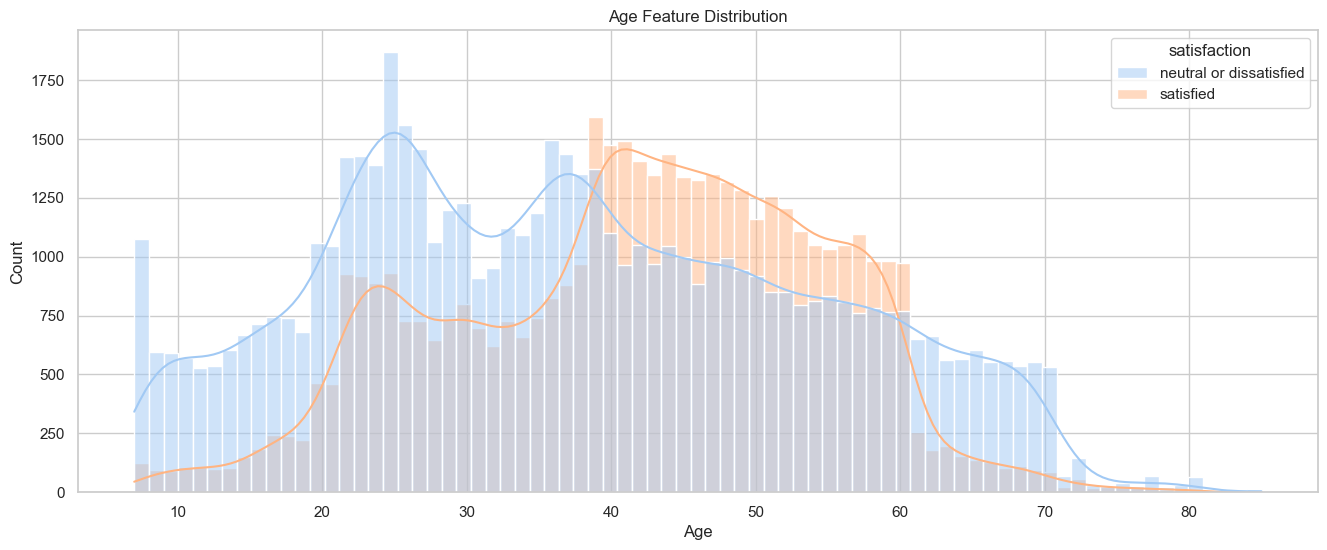

In [32]:
plt.figure(figsize=(16,6))
sns.histplot(data=df, x="Age",  hue='satisfaction', kde= True)
plt.title('Age Feature Distribution')

### - Intentamos hacer graficos de barras para visualizar si las respuestas estan en una desigualdad alta

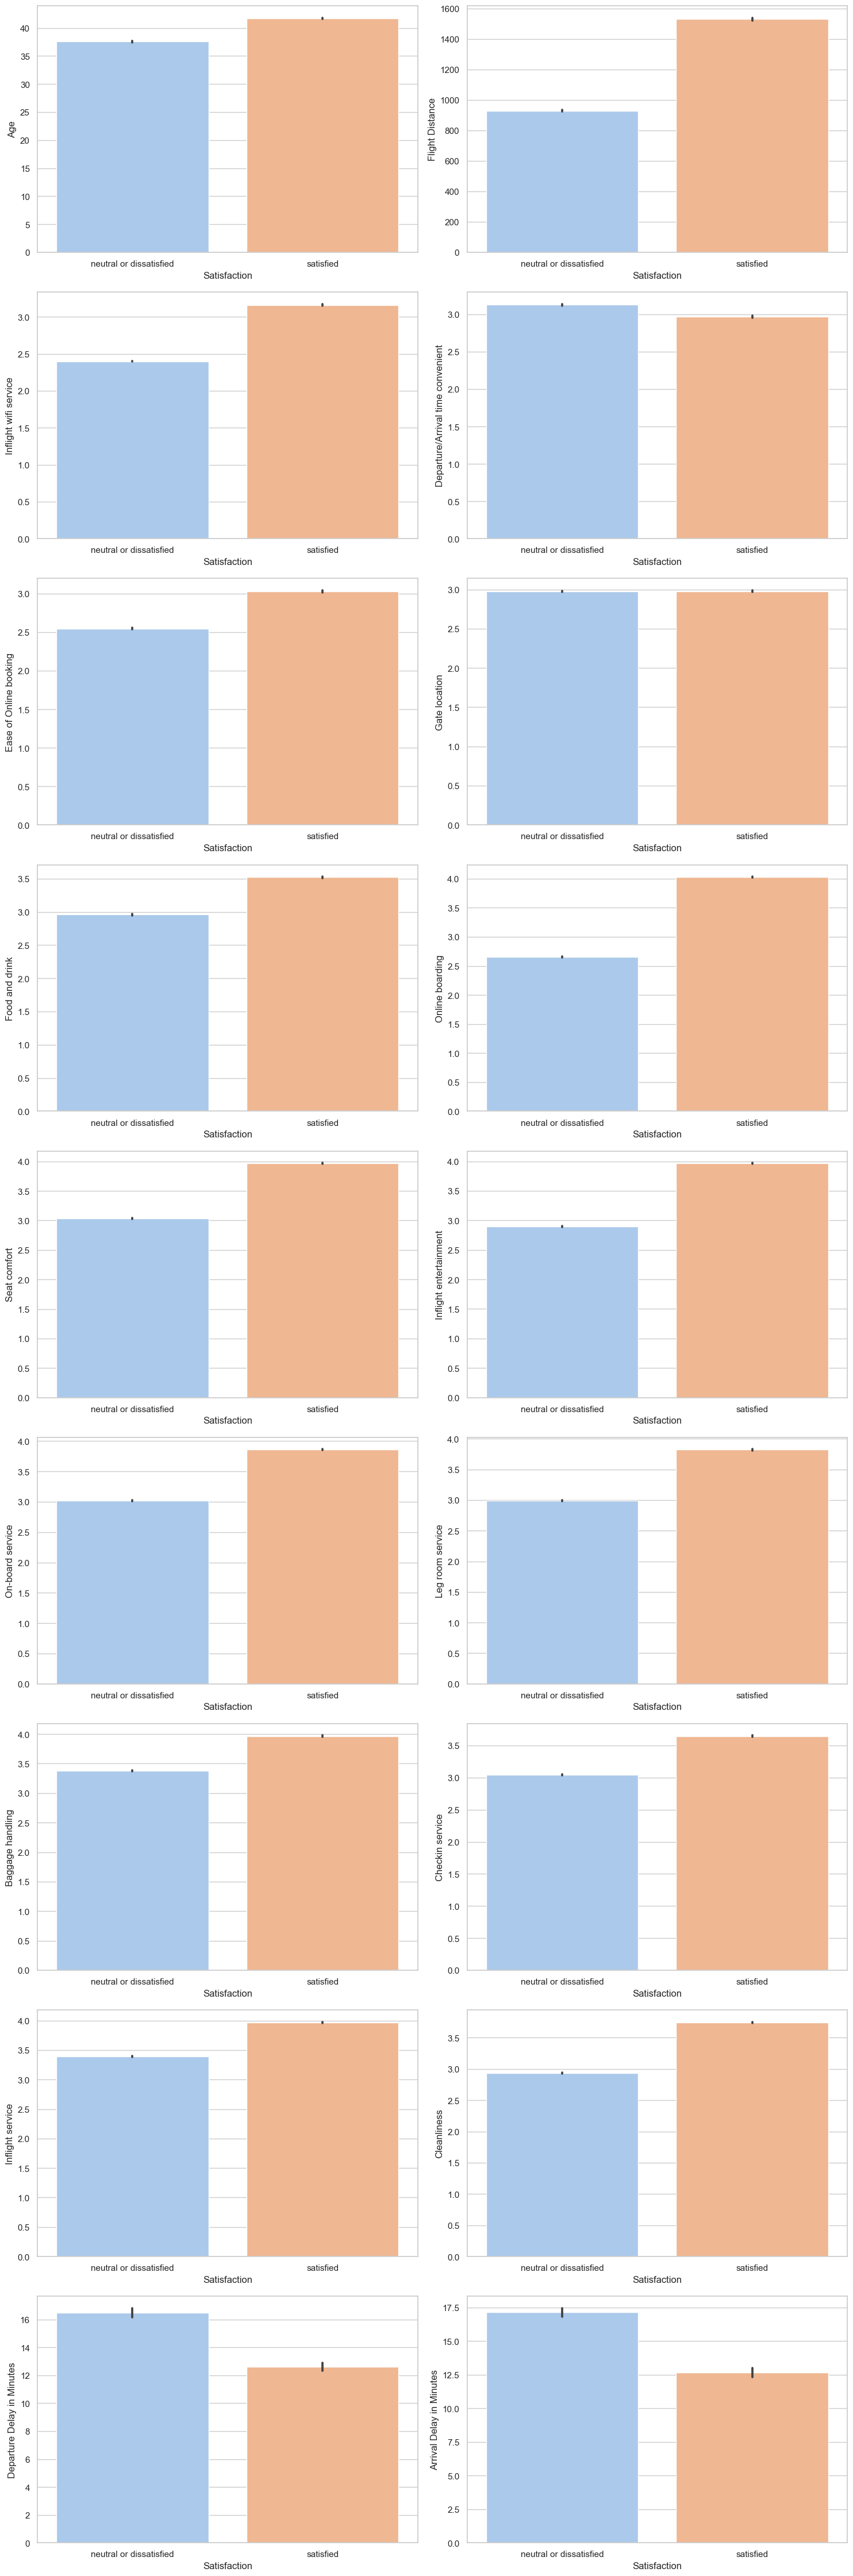

In [33]:
# Calcula el número de filas y columnas para organizar los subplots
n_rows, n_cols = math.ceil(len(num_cols) / 2), 2

# Crea la figura y los ejes de los subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for num_col in num_cols:
    row = i // n_cols
    col = i % n_cols
    sns.barplot(data=df, x="satisfaction", y=num_col, ax=ax[row, col])
    ax[row, col].set_xlabel("Satisfaction", fontsize=12)
    ax[row, col].set_ylabel(num_col, fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

# CamelCase para `Customer Type`

In [34]:
df['Customer Type'].head()

0       Loyal Customer
1    disloyal Customer
2       Loyal Customer
3       Loyal Customer
4       Loyal Customer
Name: Customer Type, dtype: object

In [35]:
# Cambiar solo 'disloyal Customer' a 'Disloyal Customer'. Acordarme de ponerlo en el pipeline
df.loc[df['Customer Type'] == 'disloyal Customer', 'Customer Type'] = 'Disloyal Customer'

In [36]:
df['Customer Type'].head()

0       Loyal Customer
1    Disloyal Customer
2       Loyal Customer
3       Loyal Customer
4       Loyal Customer
Name: Customer Type, dtype: object

In [37]:
df[["Seat comfort"]].value_counts()

Seat comfort
4               31765
5               26470
3               18696
2               14897
1               12075
0                   1
Name: count, dtype: int64

In [38]:
df[["Inflight wifi service"]].value_counts()

Inflight wifi service
3                        25868
2                        25830
4                        19794
1                        17840
5                        11469
0                         3103
Name: count, dtype: int64

### MAPA DE CORRELACION CON COLUMNAS NUMERICAS

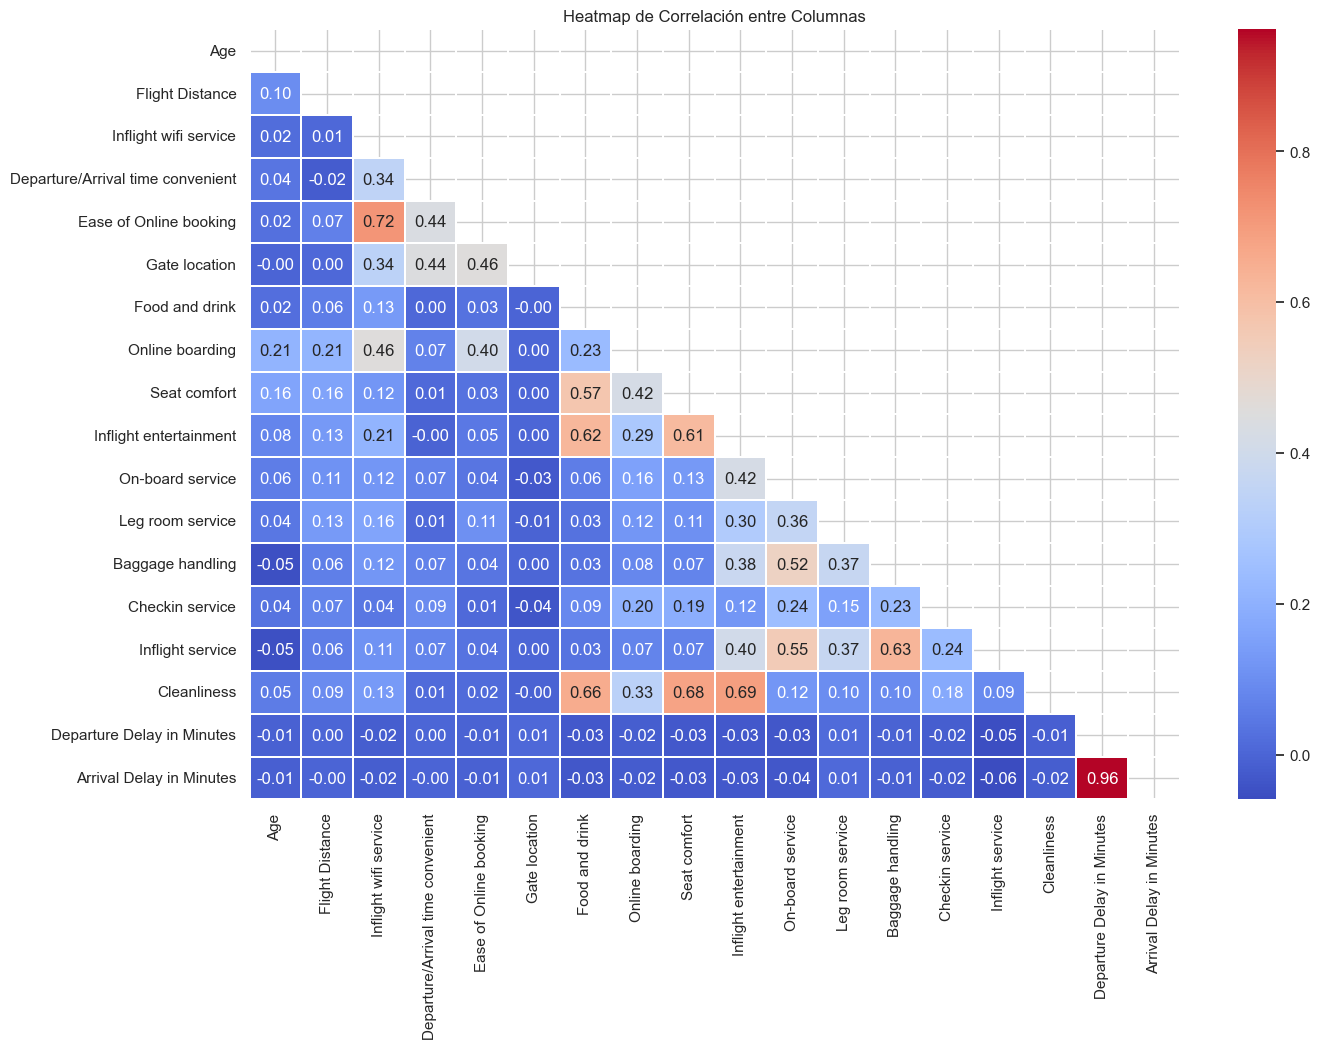

In [39]:
correlacion_numericas = df[num_cols].corr()

# Generamos una máscara para no duplicar los valores
mask = np.triu(np.ones_like(correlacion_numericas, dtype=bool))
#sns.heatmap(correlacion_numericas , mask = mask, annot =True , linewidth =0.2)

# Crear el heatmap
plt.figure(figsize=(15, 10))  # Ajusta el tamaño de la figura, puede ponerse o no.10,8
#sns.heatmap(correlacion_numericas , mask = mask, annot =True , linewidth =0.2)
sns.heatmap(correlacion_numericas,  mask = mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2) # lw= 0.5
plt.title('Heatmap de Correlación entre Columnas')
plt.show()

# ANALISIS DE VARIABLES CATEGORICAS

### Revisamos cuantas y cuales columnas categoricas hay

In [40]:
cat_cols =[column for column, count in dict(df.nunique()).items()
             if (df[column].dtype=="O") & (count<10)]
cat_cols

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

### Obtenemos las columnas con sus datos categoricos

In [41]:
# Obtener categorías únicas (incluyendo valores nulos) de las columnas deseadas
categorias_por_columna = {}
for columna in cat_cols:
    categorias = df[columna].unique()
    categorias = [str(cat) if not pd.isnull(cat) else 'NaN' for cat in categorias]
    categorias_por_columna[columna] = categorias

# Mostrar las categorías en una tabla usando tabulate
tabla = []
for columna, categorias in categorias_por_columna.items():
    tabla.append([columna, ", ".join(categorias)])

tabla_formateada = tabulate(tabla, headers=["Columna", "Datos Categorícos (con Nulos)"], tablefmt="grid")
print(tabla_formateada)

+----------------+------------------------------------+
| Columna        | Datos Categorícos (con Nulos)      |
+================+====================================+
| Gender         | Male, Female                       |
+----------------+------------------------------------+
| Customer Type  | Loyal Customer, Disloyal Customer  |
+----------------+------------------------------------+
| Type of Travel | Personal Travel, Business travel   |
+----------------+------------------------------------+
| Class          | Eco Plus, Business, Eco            |
+----------------+------------------------------------+
| satisfaction   | neutral or dissatisfied, satisfied |
+----------------+------------------------------------+


### VISUALIZAMOS CON GRAFICO DE BARRAS LAS VARIABLES CATEGORICAS

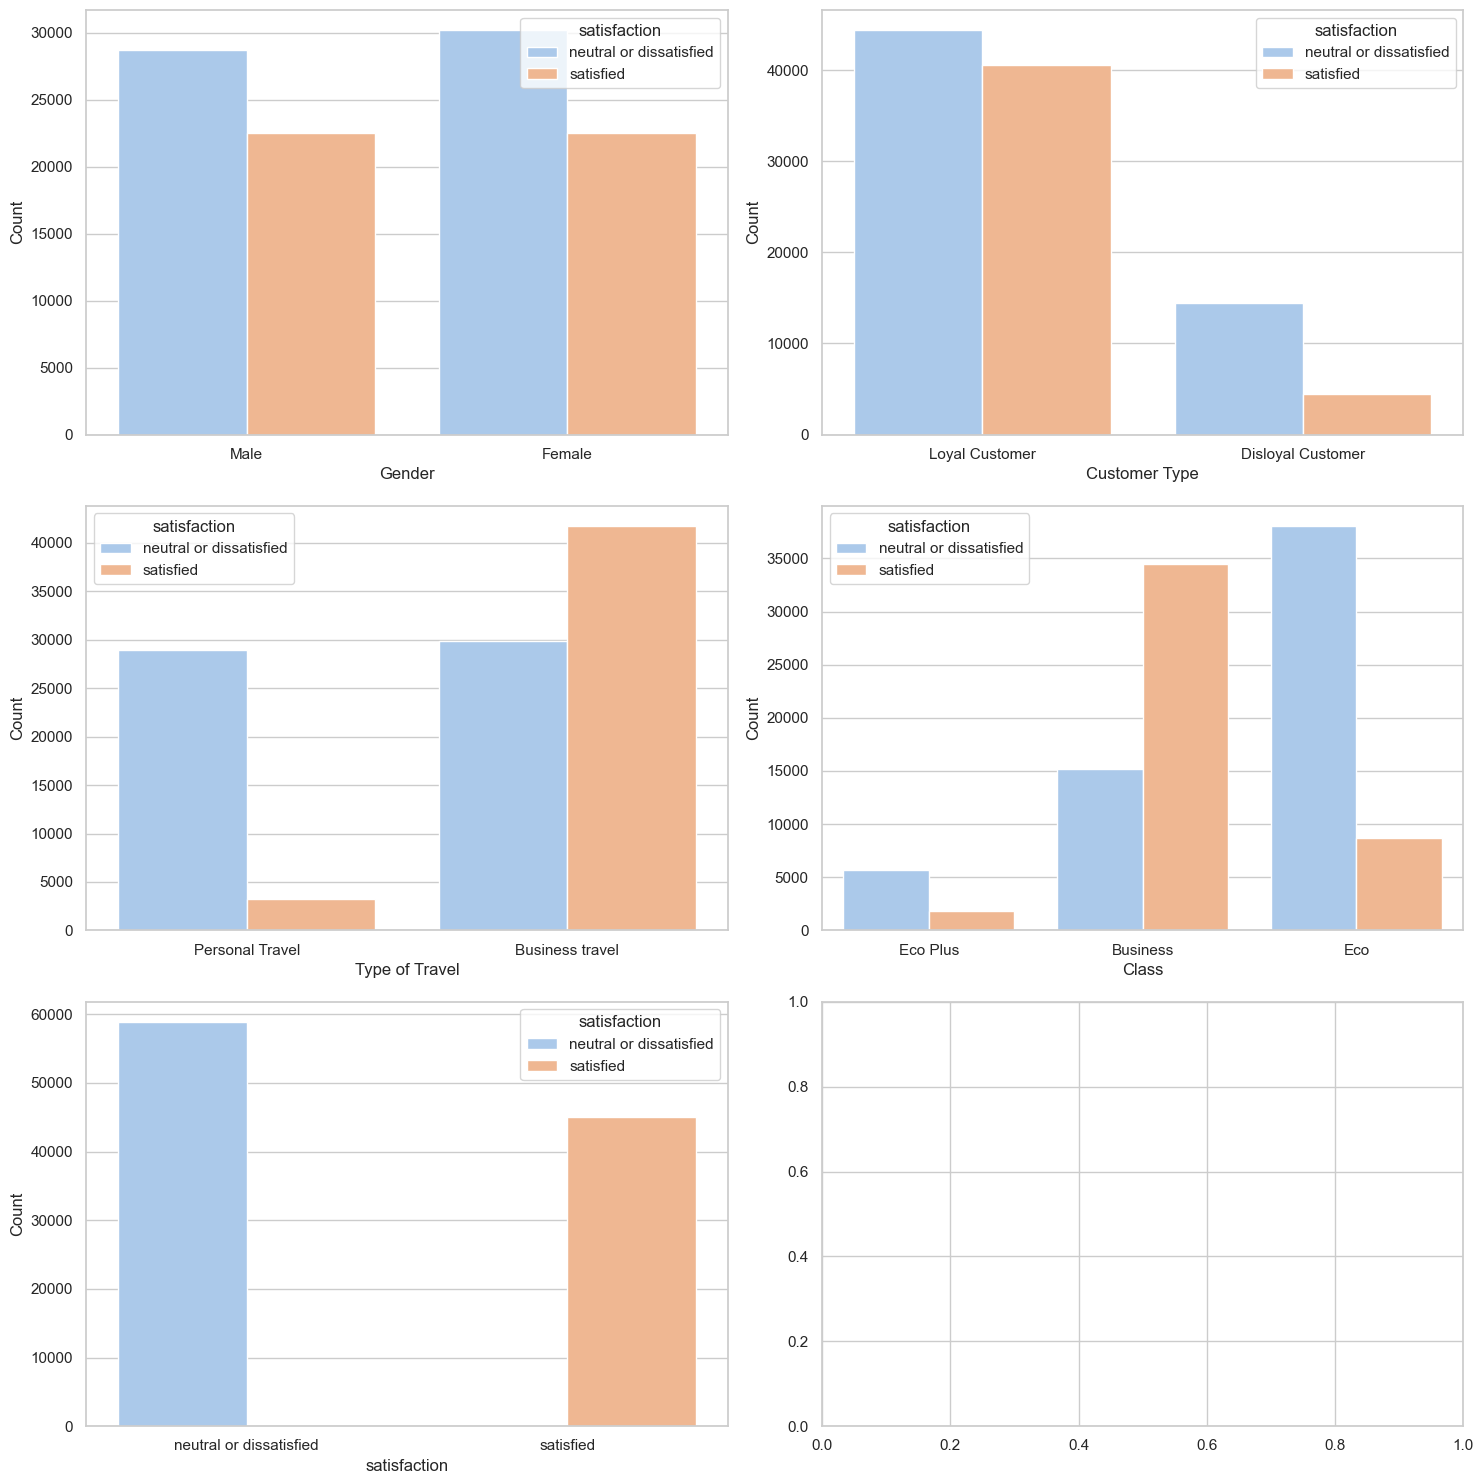

In [42]:
# Calcula el número de filas y columnas para organizar los subplots
n_rows, n_cols = math.ceil(len(cat_cols) / 2), 2

# Crea la figura y los ejes de los subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for var_cat in cat_cols:
    row = i // n_cols
    col = i % n_cols
    sns.countplot(data=df, x=var_cat, hue="satisfaction", ax=ax[row, col])
    ax[row, col].set_xlabel(var_cat, fontsize=12)
    ax[row, col].set_ylabel('Count', fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

# OUTLIERS

EL SIGUIENTE CODIGO SE USARÁN PARA BUSCAR OUTLIERS Y BORRARLOS

In [43]:
mean = df["Flight Distance"].mean()
std = df["Flight Distance"].std()

threshold = 3 * std

outliers = df[abs(df["Flight Distance"] - mean) > threshold]

In [44]:
df = df.drop(index=outliers.index)

# PRE PROCESAMIENTO: DIVISION DE DATOS

### Columnas Numéricas y Columnas Categóricas

In [45]:
num_cols = ["Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient", "Ease of Online booking",
                 "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service",
                 "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness", "Departure Delay in Minutes",
                 "Arrival Delay in Minutes"]

cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

### Diccionario que guarda los modelos a probar

In [46]:
modelos = [
    #RandomForestClassifier(),
    #HistGradientBoostingClassifier(),
    AdaBoostClassifier(),
    #GradientBoostingClassifier()
]

## SEPARACION DE CARACTERISTICAS Y VARIABLE OBJETIVO

In [47]:
# Separar Variable Objetivo, target o variable dependiente de las variables independientes
df_f = pd.DataFrame(df)
y = df_f["satisfaction"]
X = df_f.drop(columns="satisfaction")

In [48]:
# Se crea un diccionario para almacenar los resultados de cada modelo
resultados_por_modelo = {}

Model has feature importances. Displaying them.
Ranking of most important features:

1. Feature Inflight wifi service (Importance: 0.14)
2. Feature Online boarding (Importance: 0.1)
3. Feature Type of Travel_Business travel (Importance: 0.08)
4. Feature Seat comfort (Importance: 0.08)
5. Feature Baggage handling (Importance: 0.06)
6. Feature Customer Type_Disloyal Customer (Importance: 0.06)
7. Feature Leg room service (Importance: 0.06)
8. Feature Inflight service (Importance: 0.06)
9. Feature Checkin service (Importance: 0.04)
10. Feature Departure/Arrival time convenient (Importance: 0.04)
Resultados para el modelo AdaBoostClassifier:
Fit_time: 4.39
Accuracy: 0.93
F1: 0.93
Recall: 0.93
Precision: 0.93
Overfitting: -0.03
Confusion Matrix of AdaBoostClassifier model is:


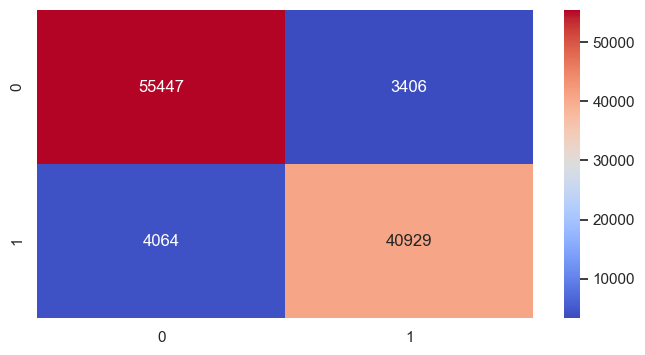

In [49]:
# Itera sobre los modelos
for modelo in modelos:
    # Entrena y evalúa el modelo actual
    resultados = model_pred(modelo, X, y, save_pickle)
        
    # Almacena los resultados en el diccionario
    nombre_modelo = type(modelo).__name__
    resultados_por_modelo[nombre_modelo] = resultados
    

#for nombre_modelo, resultados in resultados_por_modelo.items():
    print(f"Resultados para el modelo {nombre_modelo}:")
    for metrica, valor in resultados.items():
        if metrica in ['fit_time', 'accuracy', 'f1', 'recall', 'precision', 'overfitting']:
            print(f"{metrica.capitalize()}: {valor:.2f}")
        if metrica in ['cm']:
            print(f"Confusion Matrix of {nombre_modelo} model is:")

    # Se obtiene la matriz de confusión del diccionario de resultados
    matriz_confusion = resultados['cm']

    plt.figure(figsize=(8,4))
    sns.heatmap(matriz_confusion,annot=True,fmt="g",cmap='coolwarm')
    plt.show()






In [50]:
# Definir los mejores parámetros (estos parametros se definieron ya habiendo corrido
# la sigueinte linea de cosigo que buscaron los mejores parametros)
##best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}

# Crear un modelo de Gradient Boosting con los mejores parámetros
##gb_model = GradientBoostingClassifier(**best_params)

# Crear el pipeline que combina el preprocesador y el modelo.
#pipeline = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('gradient_boosting', gb_model)
#])

## BUSQUEDA DE HIPERPARAMETROS

Con este codigo se buscaron los mejores hiperparametro los cuales se utilizan y ya se comenta para no tener que usar mas esta linea de codigo y poner mas lento el programa.

Best Gradient Boosting Model - Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}

In [51]:
# Definir la cuadrícula de hiperparámetros a explorar
# param_grid = {
    #'n_estimators': [50, 100, 150],
    #'learning_rate': [0.01, 0.1, 0.2],
    #'max_depth': [3, 5, 7]

# Realizar Grid Search con validación cruzada
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
# best_params = grid_search.best_params_
# best_gb_model = grid_search.best_estimator_

# print("Best Gradient Boosting Model - Best Params:", best_params)

- A continuación, podemos usar el pipeline para entrenar y evaluar tu modelo.
Por ejemplo, puedes ajustar el pipeline a tus datos de entrenamiento y realizar predicciones:


# Entrenar con todos los datos al modelo escogido
#### Guardar el pickle ####

Model has feature importances. Displaying them.
Ranking of most important features:

1. Feature Age (Importance: 0.12)
2. Feature Flight Distance (Importance: 0.07)
3. Feature Seat comfort (Importance: 0.065)
4. Feature Inflight wifi service (Importance: 0.065)
5. Feature Departure/Arrival time convenient (Importance: 0.065)
6. Feature Online boarding (Importance: 0.06)
7. Feature Inflight entertainment (Importance: 0.06)
8. Feature Leg room service (Importance: 0.055)
9. Feature Ease of Online booking (Importance: 0.05)
10. Feature Inflight service (Importance: 0.045)


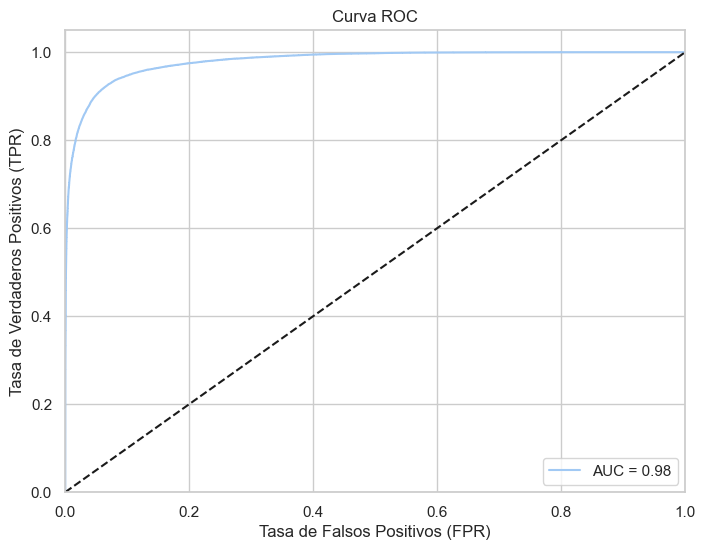

In [52]:
# Supongamos que escogemos AdaBoostClassifier. Volvemos a llamar a la función model_pred()

# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = True 
model_pred(AdaBoostClassifier(n_estimators=200,  random_state=1), X, y, save_pickle)

model = AdaBoostClassifier(n_estimators=200,  random_state=1)
pipeline = create_pipeline(model, num_cols, cat_cols)
pipeline.fit(X, y)
y_prob = pipeline.predict_proba(X)[:, 1]
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label='satisfied')

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(y, y_prob)
# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
save_pickle = False



In [57]:
import azureml
import azureml.core
from azureml.core import Workspace, Experiment, Model

# Crear un espacio de trabajo de Azure Machine Learning
ws = azureml.core.Workspace(subscription_id="0f45f656-3010-4bfe-9d66-367b1ba14470",
                                resource_group="F5AIRLINE",
                                workspace_name="F5AIRLINE")

# Crear un objeto de registro de modelo
#model_registry = azureml.core.ModelRegistry(workspace=ws)

# Define un experimento para el registro del modelo
experiment_name = "my-experimentF5AIRLINE"
experiment = Experiment(workspace=ws, name=experiment_name)

# Guardar el modelo en el registro de modelo
model_name = "data_pipeline"
model_path = "./data_pipeline.pkl"
#model_registry.register_model(model_name, model_path)

model = Model.register(model_path=model_path, model_name=model_name, workspace=ws)

Registering model data_pipeline


# ANALISIS DE CORRELACIÓN


### CONCLUSIÓN

- Edad: La edad tiene una correlación positiva débil (0.137) con la satisfacción. Esto sugiere que los pasajeros mayores tienden a estar ligeramente más satisfechos en comparación con los pasajeros más jóvenes.
- Distancia del Vuelo (Flight Distance): La distancia del vuelo tiene una correlación negativa moderada (-0.299) con la satisfacción. Esto indica que a medida que la distancia del vuelo aumenta, la satisfacción tiende a disminuir. Los vuelos más largos podrían estar asociados con niveles de satisfacción más bajos.
  
- Embarque en Línea (Online Boarding): La variable "Online Boarding" tiene una correlación negativa fuerte (-0.503) con la satisfacción. Esto significa que los pasajeros que tienen una experiencia de embarque en línea mejor tienden a estar más satisfechos con el servicio.
  
- Comodidad del Asiento (Seat Comfort): La comodidad del asiento tiene una correlación positiva fuerte (0.349) con la satisfacción. Los pasajeros que encuentran cómodos los asientos tienden a estar más satisfechos.

- Entretenimiento a Bordo (Inflight Entertainment): El entretenimiento a bordo tiene una correlación positiva fuerte (0.398) con la satisfacción. Los pasajeros que disfrutan del entretenimiento a bordo tienden a estar más satisfechos.

- Limpieza (Cleanliness): La limpieza tiene una correlación positiva moderada (0.305) con la satisfacción. Los pasajeros que perciben que la cabina está limpia tienden a estar más satisfechos.
  
- Clase (Class): La clase de vuelo también tiene una influencia en la satisfacción. La variable "Class_Eco" tiene una correlación negativa moderada con la satisfacción, mientras que "Class_Business" tiene una correlación positiva moderada. Esto sugiere que los pasajeros de clase económica pueden estar menos satisfechos en comparación con los pasajeros de clase business.
  
- Tipo de Viaje (Type of Travel): La variable "Type of Travel_Personal Travel" tiene una correlación negativa moderada con la satisfacción, lo que sugiere que los viajes de negocios podrían estar asociados con niveles de satisfacción más altos en comparación con los viajes personales.
  
- Tipo de Cliente (Customer Type): La variable "Customer Type_Loyal Customer" tiene una correlación positiva moderada con la satisfacción, lo que sugiere que los clientes leales tienden a estar más satisfechos.
  
- Tiempo de Llegada y Salida Conveniente (Departure/Arrival Time Convenient): Esta característica tiene una correlación positiva débil (0.052) con la satisfacción. Los pasajeros que consideran que el tiempo de llegada y salida es conveniente tienden a estar ligeramente más satisfechos.